In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(plyr)
library(dplyr)
#library(tidyr)
library(ggplot2)
library(RColorBrewer)

In [4]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [5]:
%%R
physeq.noSmall <- subset_samples(physeq,sample_sums(physeq)>=1500)

In [6]:
%%R
mdf = psmelt(physeq)

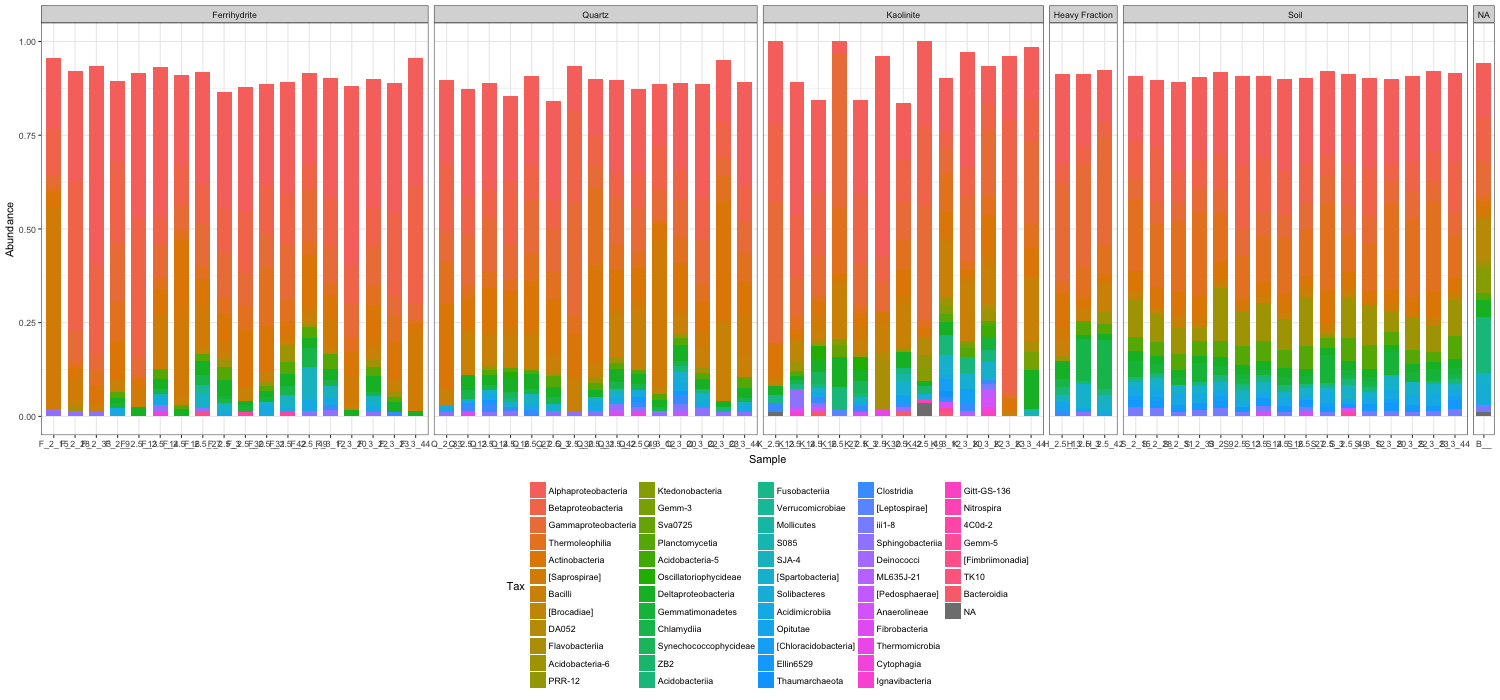

In [7]:
%%R -w 1500 -h 700

cutoff = 0.01
totabund = 00

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, Class, Trtmt) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

#scheme <- iwanthue()
#colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

#p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

#p = p + theme(axis.text.x=theme_text(angle=-90))

p = p + theme_bw()

p = p + theme(legend.position="bottom")

p

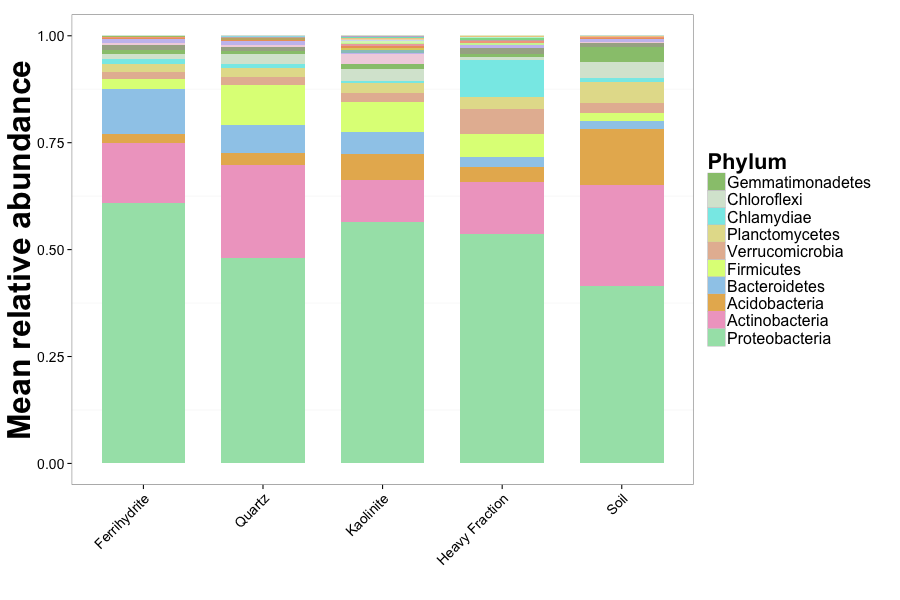

In [7]:
%%R -w 900 -h 600

cutoff = 0.00
totabund = 1500

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Phylum = ifelse(is.na(d.plot$Phylum)==TRUE, "Unidentified", paste(d.plot$Phylum))
d.plot$Phylum = ifelse(d.plot$Phylum=="unidentified", "Unidentified", paste(d.plot$Phylum))
d.plot = d.plot %>%
    group_by(Trtmt, Phylum, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Phylum) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt) %>%
    group_by(Trtmt,Phylum)%>%
    summarize(Abundance = mean(Abundance))

colnames(d.plot) <- c("Trtmt", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order( Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

#p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

N=10
Phyla=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]
p = p + scale_fill_manual(values = colors, breaks = Phyla)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 1, title = "Phylum", reverse="TRUE"))

#p = p + theme(axis.text.y=theme_text(angle=-90))

p = p + ylab("Mean relative abundance") + xlab("")

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(size = 14, angle = 45, hjust=1),
              axis.text.y = element_text(size = 14), 
              axis.title.x = element_text(size = 28),
              axis.title.y = element_text(size = 32,vjust=1,face='bold'),
              legend.title = element_text(size=22),
              legend.text = element_text(size = 16))

p = p + theme(legend.position="right", panel.grid.major= element_blank())

p

In [9]:
%%R
ggsave(filename="RelabundPhylum16SCombMonths.jpg", p, width=7, height=8.6)

### Making box charts instead of stacked

In [8]:
%%R
d = mdf %>%
    filter(Month!=2.0)%>%
    group_by(Phylum) %>%
    summarize(Abundance = sum(Abundance))
Porder = na.omit(d$Phylum[order(-d$Abundance)])
Porder
# Ordering the phyla roughly in order of total abundance

 [1] Proteobacteria   Actinobacteria   Bacteroidetes    Firmicutes      
 [5] Acidobacteria    Planctomycetes   Verrucomicrobia  Chloroflexi     
 [9] Chlamydiae       TM6              Gemmatimonadetes Armatimonadetes 
[13] Cyanobacteria    Fibrobacteres    Chlorobi         Crenarchaeota   
[17] FBP              Nitrospirae      OD1              TM7             
[21] BRC1             BHI80-139        NKB19            Elusimicrobia   
[25] [Thermi]         WPS-2            Tenericutes      Aquificae       
[29] Fusobacteria     AD3              WS3              OP11            
[33] WS2              Spirochaetes     WWE1             OP3             
[37] Synergistetes    Euryarchaeota    GN02             SR1             
[41] Lentisphaerae    Thermotogae      Deferribacteres  OP8             
[45] Dictyoglomi      FCPU426          NC10             OP1             
[49] WS4              GN04             Chrysiogenetes   [Parvarchaeota] 
[53] SAR406           SBR1093          Caldiserica 

In [9]:
%%R
Porder[Porder!="Chlamydiae"]

 [1] Proteobacteria   Actinobacteria   Bacteroidetes    Firmicutes      
 [5] Acidobacteria    Planctomycetes   Verrucomicrobia  Chloroflexi     
 [9] TM6              Gemmatimonadetes Armatimonadetes  Cyanobacteria   
[13] Fibrobacteres    Chlorobi         Crenarchaeota    FBP             
[17] Nitrospirae      OD1              TM7              BRC1            
[21] BHI80-139        NKB19            Elusimicrobia    [Thermi]        
[25] WPS-2            Tenericutes      Aquificae        Fusobacteria    
[29] AD3              WS3              OP11             WS2             
[33] Spirochaetes     WWE1             OP3              Synergistetes   
[37] Euryarchaeota    GN02             SR1              Lentisphaerae   
[41] Thermotogae      Deferribacteres  OP8              Dictyoglomi     
[45] FCPU426          NC10             OP1              WS4             
[49] GN04             Chrysiogenetes   [Parvarchaeota]  SAR406          
[53] SBR1093          Caldiserica      [Caldithrix]

In [10]:
%%R

# Setting up the data so we don't have to re-run each time
Porder = Porder[Porder!="Chlamydiae"]
# Cutting out Chlamydiae b/c it's largely from weird HF sample

cutoff = 0.01
totabund = 1500
nphyla = 10

Porder = Porder[1:nphyla]
# Selects only the Phyla from the top nphyla (usu. 10)


# For a given sample, I want to make sure that if a phylum from my list is not present,
# we assign it a value of zero. I guess we need to get all the sample IDs

d.plot = mdf %>%
    group_by(Sample) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    filter(Month != 2.0)%>%
    group_by(Phylum, Sample, Trtmt) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Phylum %in% Porder)%>%
    arrange(Trtmt, Abundance)

d.plot$Phylum = factor(d.plot$Phylum, levels = Porder)
d.plot = d.plot[with(d.plot, order(d.plot$Phylum)),]
d.plot$Trtmt = factor(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
# Changing labels, setting orders, etc.

d.plot = d.plot %>%
    expand(Sample, Phylum) %>%
    left_join(d.plot)%>%
    group_by(Sample, Phylum, Trtmt)%>%
    summarise(Abundance = sum(Abundance, na.rm=TRUE))
# Taking the data, and making all possible combinations of sample, phylum, and treatment
# Then, we match up our actual data with our abundance counts, etc.
# And, we don't want there to be NAs, so we sum the total for each possibility

# But we also need non-presences to be counted.

SampTrtmt = na.omit(unique(d.plot[c("Sample", "Trtmt")]))
# Creating a list of sample IDs matched with their treatment

d.plot = merge(d.plot[,c(1,2,4)], SampTrtmt, by="Sample")
# Merging the two tables, but forgetting the old Trtmt column
d.plot


Error in function_list[[i]](value) : could not find function "expand"


/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in function_list[[i]](value) : could not find function "expand"

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: package ‘ggplot2’ was built under R version 3.3.2 

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: 
  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In asMethod(object) :
  warnings.warn(x, RRuntimeWarning)

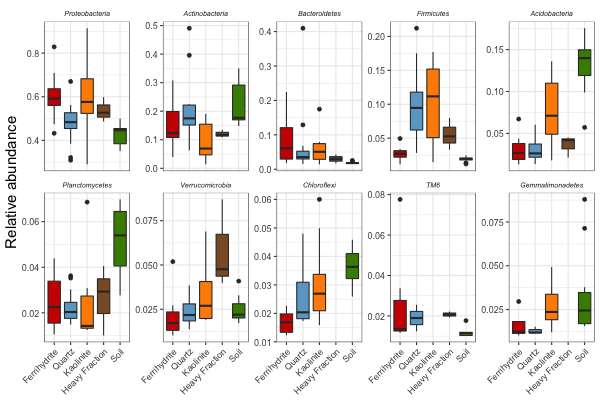

In [15]:
%%R -w 600 -h 400

p = ggplot(d.plot, aes(Trtmt, Abundance, fill = Trtmt))

p = p + geom_boxplot()

p = p + facet_wrap(~Phylum, scales = "free_y",nrow=2)

p = p + scale_fill_manual(values=c("red3","skyblue3","darkorange","tan4","chartreuse4","gold1"))

p = p + theme_bw()

p = p + guides(fill = "none")
p = p + theme(legend.position = "none")

p = p + theme(strip.text.x = element_text(size=7, face="italic"), 
              strip.text.y = element_text(size=9), 
                strip.background = element_rect(colour="white", fill="white"))

p = p + theme(axis.text.x = element_text(size = 9, angle = 45, hjust=1),axis.text.y = element_text(size = 9))
p = p + theme(axis.title.x = element_blank())
p = p + theme(axis.title.y = element_text(size = 15, vjust = 1))

p = p + labs(x="Amendment",y="Relative abundance")

p

In [16]:
%%R
ggsave(filename="RelabundPhylum16S2MonthsBox.jpg", p, width=7, height=4)

In [15]:
%%R
m = SampTrtmt%>%
    group_by(Trtmt)%>%
    summarize(count=n())
m

Source: local data frame [5 x 2]

           Trtmt count
1   Ferrihydrite    14
2         Quartz    14
3      Kaolinite    13
4 Heavy Fraction     3
5           Soil    11


In [21]:
%%R
Phyla = unique(d.plot$Phylum)
Phyla

 [1] Proteobacteria   Actinobacteria   Bacteroidetes    Firmicutes      
 [5] Acidobacteria    Planctomycetes   Verrucomicrobia  Chloroflexi     
 [9] TM6              Gemmatimonadetes
10 Levels: Proteobacteria Actinobacteria Bacteroidetes ... Gemmatimonadetes


In [32]:
%%R
for(i in Phyla){
    a = d.plot%>%
        filter(Phylum==i)
    anova=aov(a$Abundance~a$Trtmt)
    Tukey=TukeyHSD(anova)
    print(i)
    print(summary(anova))
    print(Tukey)}

[1] "Proteobacteria"
            Df Sum Sq Mean Sq F value  Pr(>F)   
a$Trtmt      4 0.2692 0.06730    5.08 0.00163 **
Residuals   50 0.6625 0.01325                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = a$Abundance ~ a$Trtmt)

$`a$Trtmt`
                                    diff         lwr          upr     p adj
Quartz-Ferrihydrite         -0.119232468 -0.24234603  0.003881099 0.0619440
Kaolinite-Ferrihydrite      -0.009680497 -0.13513929  0.115778301 0.9994771
Heavy Fraction-Ferrihydrite -0.062517336 -0.26974835  0.144713677 0.9121720
Soil-Ferrihydrite           -0.174123877 -0.30536338 -0.042884374 0.0039740
Kaolinite-Quartz             0.109551970 -0.01590683  0.235010768 0.1137990
Heavy Fraction-Quartz        0.056715132 -0.15051588  0.263946145 0.9367834
Soil-Quartz                 -0.054891409 -0.18613091  0.076348094 0.7606147
Heavy Fraction-Kaolinite   

###Making a plot for Soil Science lecture


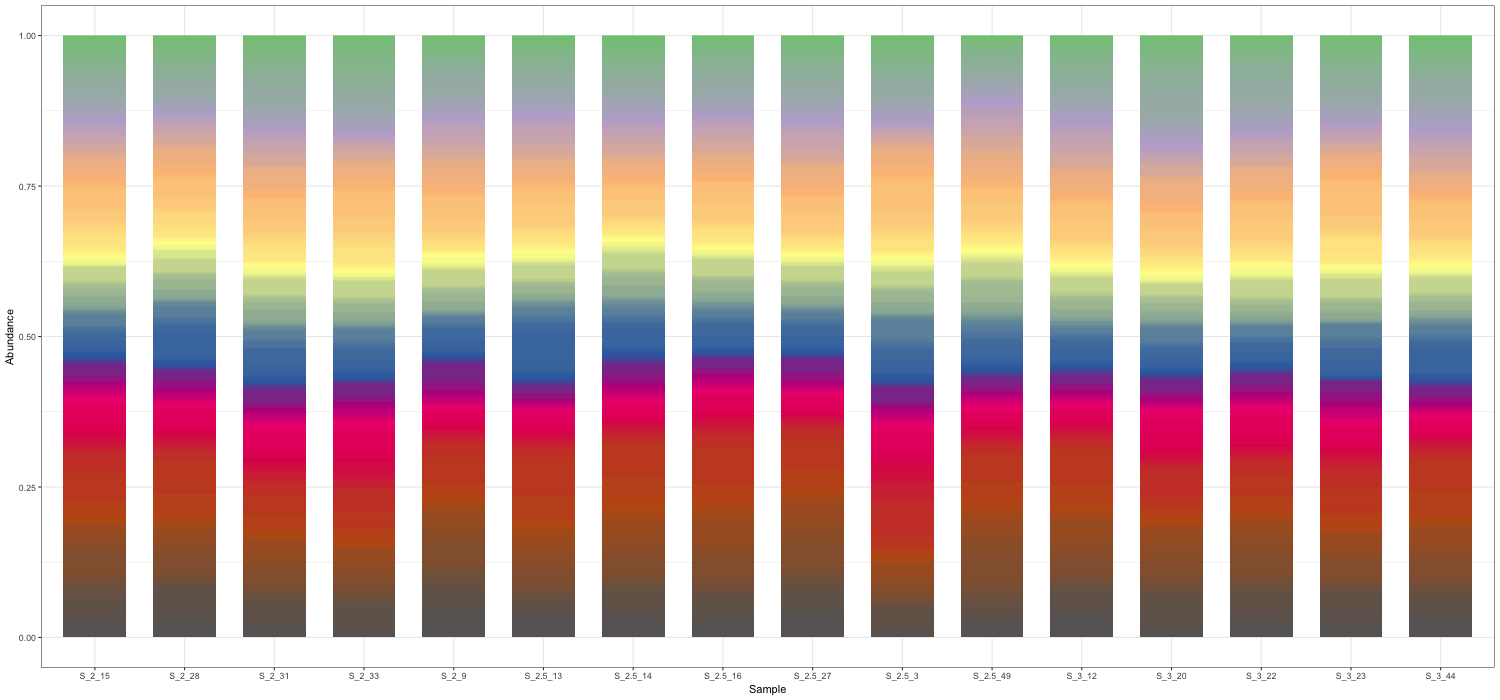

In [12]:
%%R -w 1500 -h 700

cutoff = 0.00001
totabund = 00

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, OTU, Trtmt) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Trtmt == "Soil")%>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Abundance")

#mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
#d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

#d.plot<-d.plot[with(d.plot, order(Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

#scheme <- iwanthue()
#colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

#p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

#p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

colourCount = length(unique(d.plot$Tax))
getPalette = colorRampPalette(brewer.pal(12, "Accent"))

p = p + scale_fill_manual(values = getPalette(colourCount))

#p = p + theme(axis.text.x=theme_text(angle=-90))

p = p + theme_bw()

p = p + theme(legend.position="none")

p

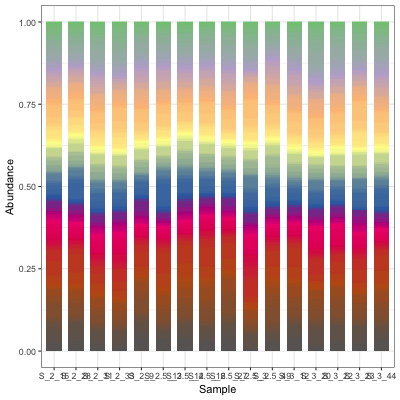

In [16]:
%%R -h 400 -w 400
p

In [17]:
%%R
colourCount

[1] 4872
